# Double Moving Average Crossover Trading Strategy

The Double Moving Average Crossover is one of the simplest yet powerful trading strategies used by both beginners and seasoned traders. By using two different moving averages, this strategy identifies potential buy and sell signals when the faster moving average crosses over or under a slower one. In this notebook, we implement this strategy in Python, backtest it, and analyze the results.

## Import Libraries

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from tabulate import tabulate
from datetime import datetime

## Prepare Stock Data
We now download the data using `yfinance` and preprocess the data for visualization and backtesting

In [97]:
# Define the stock symbol and the date range for our data
stock_symbol = 'TSLA'
start_date = '2024-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')  # Sets end date to today's date
print(f"Double Moving Average Crossover Trading for: {stock_symbol}\nStart Date: {start_date}\nEnd Date: {end_date}")

Double Moving Average Crossover Trading for: TSLA
Start Date: 2024-01-01
End Date: 2024-11-13


In [98]:
df = yf.download(stock_symbol, start=start_date, end=end_date)

# Select the desired columns (first level of MultiIndex)
df.columns = df.columns.get_level_values(0)

# Keep only the columns you are interested in
df = df[['Open', 'Close', 'Volume', 'Low', 'High']]

# If the index already contains the dates, rename the index
df.index.name = 'Date'  # Ensure the index is named "Date"
    
# Resetting the index if necessary
df.reset_index(inplace=True)

# Ensure that the index is of type datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index again (in case it's reset)
df.set_index('Date', inplace=True)

df.head()

[*********************100%***********************]  1 of 1 completed


Price,Open,Close,Volume,Low,High
Date,,,,,
2024-01-02 00:00:00+00:00,250.080002,248.419998,104654200,244.410004,251.250000
2024-01-03 00:00:00+00:00,244.979996,238.449997,121082600,236.320007,245.679993
2024-01-04 00:00:00+00:00,239.250000,237.929993,102629300,237.729996,242.699997
2024-01-05 00:00:00+00:00,236.860001,237.490005,92379400,234.899994,240.119995
2024-01-08 00:00:00+00:00,236.139999,240.449997,85166600,235.300003,241.250000


## Visualize Stock Chart

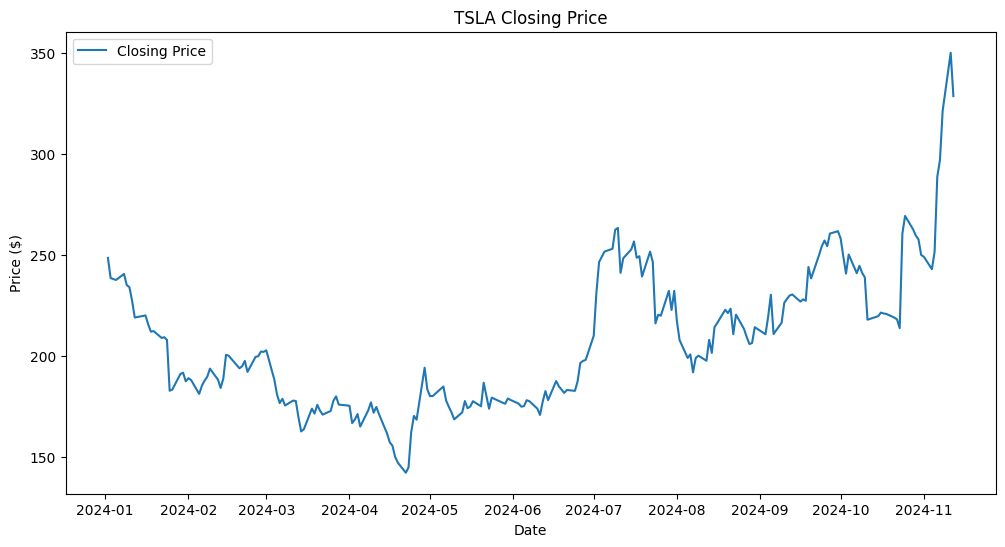

In [99]:
# Plot the closing price
plt.figure(figsize=(12, 6))

plt.plot(df['Close'], label='Closing Price')

# Add title, labels, and legend
plt.title(f'{stock_symbol} Closing Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()

# Save the plot in 300dpi
plt.savefig(f'{stock_symbol}_stock_chart.png', dpi=300)

# Show the plot
plt.show()

## Calculate Moving Averages

In this section, we calculate the short-term and long-term Exponential Moving Averages (EMAs) using two window sizes, a long and short window. The short-term EMA reacts faster to recent price changes, while the long-term EMA smooths out fluctuations to highlight longer-term trends. These moving averages help in identifying crossover points for potential buy and sell signals.

In [100]:
# Calculate the short and long EMAs
SHORT_WINDOW = 10
LONG_WINDOW = 30
df['SHORT_WINDOW'] = df['Close'].ewm(span=SHORT_WINDOW, adjust=False).mean()
df['LONG_WINDOW'] = df['Close'].ewm(span=LONG_WINDOW, adjust=False).mean()

### Visualize the Moving Averages

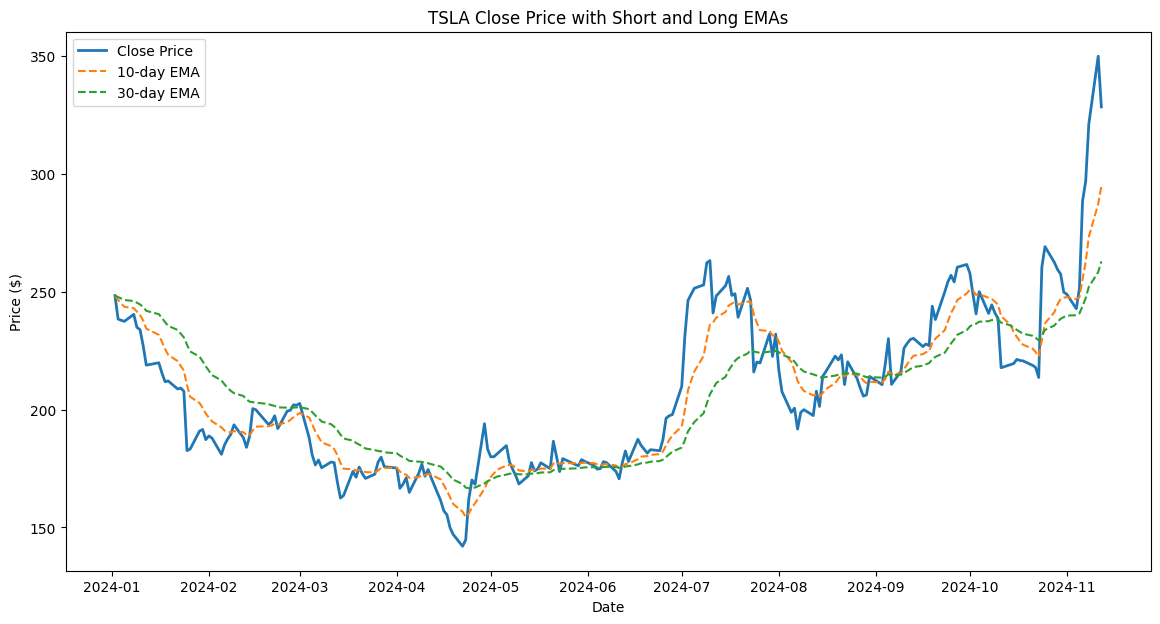

In [101]:
# Plot the Close Price and EMAs
plt.figure(figsize=(14, 7))

# Plot Close Price
plt.plot(df.index, df['Close'], label='Close Price', linewidth=2)

# Plot Short-term EMA
plt.plot(df.index, df['SHORT_WINDOW'], label=f'{SHORT_WINDOW}-day EMA', linestyle='--')

# Plot Long-term EMA
plt.plot(df.index, df['LONG_WINDOW'], label=f'{LONG_WINDOW}-day EMA', linestyle='--')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'{stock_symbol} Close Price with Short and Long EMAs')
plt.legend()

# Save plot in 300dpi
plt.savefig(f'{stock_symbol}_moving_averages.png', dpi=300)

plt.show()


### Create Buy and Sell Signals

In [102]:
# Generate buy and sell signals in a single column
df['Signal'] = np.where(
    (df['SHORT_WINDOW'] > df['LONG_WINDOW']) & (df['SHORT_WINDOW'].shift(1) <= df['LONG_WINDOW'].shift(1)), 1,  # Buy Signal
    np.where(
        (df['SHORT_WINDOW'] < df['LONG_WINDOW']) & (df['SHORT_WINDOW'].shift(1) >= df['LONG_WINDOW'].shift(1)), -1,  # Sell Signal
        0  # No Signal
    )
)

### Calculate the Brokerage Fee
In this step, we define a function to calculate the brokerage fee for each transaction. The fee is set to 0.25% of the transaction amount, with a minimum fee of $0.01 to ensure that small transactions still incur a reasonable fee. This helps simulate the costs associated with trading, making the strategy more realistic.

In [103]:
# Define the fee calculation function
def calculate_fee(amount: float) -> float:
    """Calculate the brokerage fee based on transaction amount."""
    fee = amount * 0.0025  # 0.25% of the transaction
    return max(fee, 0.01)   # Minimum fee of $0.01

### Backtest the Double Moving Average Crossover Strategy
We now test the strategy with an initial cash amount and tabulate the results

In [104]:
# Starting capital
initial_cash = 100  # Example initial capital
cash = initial_cash
shares = 0
df['Portfolio Value'] = cash

# List to store transaction details for tabulation
transaction_details = []

for i, row in df.iterrows():
    if row['Signal'] == 1 and cash > 0:  # Buy condition
        # Calculate the fee for the buy transaction
        fee = calculate_fee(cash)
        
        # Calculate how many shares can be bought after deducting the fee
        shares_bought = (cash - fee) / row['Close']
        
        # Deduct the cash and fee for the purchase
        cash -= shares_bought * row['Close'] + fee
        
        # Add the bought shares to the portfolio
        shares += shares_bought
        
        # Record transaction details
        transaction_details.append([row.name, 'Buy', round(row['Close'], 2), round(fee, 2), round(cash + (shares * row['Close']), 2)])

    elif row['Signal'] == -1 and shares > 0:  # Sell condition
        # Calculate how much cash is earned from selling shares
        total_sale_amount = shares * row['Close']
        
        # Calculate the fee for the sell transaction
        fee = calculate_fee(total_sale_amount)
        
        # Cash earned after the fee is deducted
        cash_earned = total_sale_amount - fee
        
        # Update the cash balance after selling shares
        cash += cash_earned
        
        # All shares are sold
        shares = 0
        
        # Record transaction details
        transaction_details.append([row.name, 'Sell', round(row['Close'], 2), round(fee, 2), round(cash, 2)])

    # Update portfolio value
    df.at[i, 'Portfolio Value'] = cash + (shares * row['Close'])

# Summarize results using tabulate
print(tabulate(transaction_details, headers=["Date", "Action", "Price ($)", "Fee ($)", "Portfolio Value ($)"], tablefmt="pretty"))

# Final performance
final_value = cash + (shares * df.iloc[-1]['Close'])
profit = final_value - initial_cash
print(f"\nFinal Portfolio Value: ${final_value:.2f}")
print(f"Total Profit/Loss: ${profit:.2f}")

+---------------------------+--------+-----------+---------+---------------------+
|           Date            | Action | Price ($) | Fee ($) | Portfolio Value ($) |
+---------------------------+--------+-----------+---------+---------------------+
| 2024-05-01 00:00:00+00:00 |  Buy   |  179.99   |  0.25   |        99.75        |
| 2024-06-11 00:00:00+00:00 |  Sell  |  170.66   |  0.24   |        94.34        |
| 2024-06-12 00:00:00+00:00 |  Buy   |  177.29   |  0.24   |        94.11        |
| 2024-08-05 00:00:00+00:00 |  Sell  |  198.88   |  0.26   |        105.3        |
| 2024-09-05 00:00:00+00:00 |  Buy   |  230.17   |  0.26   |       105.04        |
| 2024-10-15 00:00:00+00:00 |  Sell  |  219.57   |  0.25   |        99.95        |
| 2024-10-25 00:00:00+00:00 |  Buy   |  269.19   |  0.25   |        99.7         |
+---------------------------+--------+-----------+---------+---------------------+

Final Portfolio Value: $121.67
Total Profit/Loss: $21.67


C:\Users\Brian\AppData\Local\Temp\ipykernel_14752\742861116.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[i, 'Portfolio Value'] = cash + (shares * row['Close'])


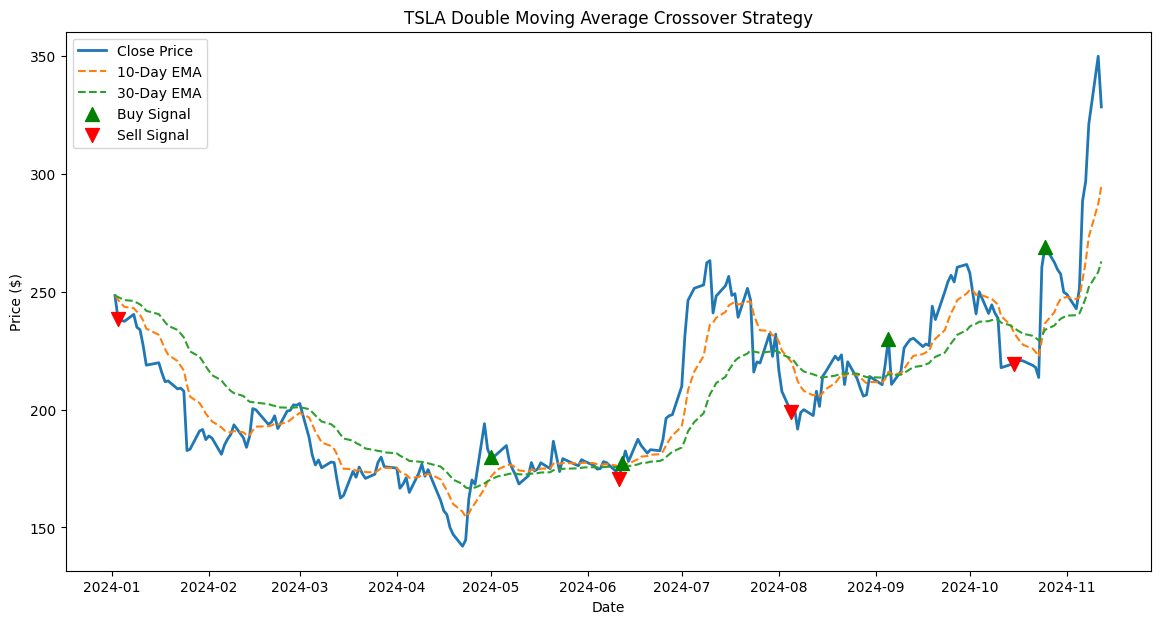

In [105]:
# Create a figure with specific size
plt.figure(figsize=(14, 7))

# Plot the closing price
plt.plot(df['Close'], label='Close Price', linewidth=2)

# Plot the short and long EMAs
plt.plot(df['SHORT_WINDOW'], label=f'{SHORT_WINDOW}-Day EMA', linestyle='--')
plt.plot(df['LONG_WINDOW'], label=f'{LONG_WINDOW}-Day EMA', linestyle='--')

# Plot Buy signals where Signal == 1
plt.scatter(df[df['Signal'] == 1].index, df[df['Signal'] == 1]['Close'], label='Buy Signal', marker='^', color='green', s=100, zorder=5)

# Plot Sell signals where Signal == -1
plt.scatter(df[df['Signal'] == -1].index, df[df['Signal'] == -1]['Close'], label='Sell Signal', marker='v', color='red', s=100, zorder=5)

# Add title, x-label, y-label, and legend
plt.title(f'{stock_symbol} Double Moving Average Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()

# Save the figure in 300dpi
plt.savefig(f'{stock_symbol}_double_crossover.png', dpi=300)

# Show the plot
plt.show()
